----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# <u>**Final Project : Introduction to AI Development**</u>

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**<u>Group 4</u>** 
---

<u>AIDI_1100</u>
---
Patel, Fenilkumar
---
Kailasam, Abishek
---
Davis, Sanath
---
Also available at https://github.com/sanathdavis/python_test/blob/main/AIDI_1100_FINAL__GROUP_4.ipynb 

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


## Preperation


*   Installs
*   Imports
*   Date Range
*   Constants



### Installs



*   StockSymbol
*   YFinance
*   SMTP
*   Emails





In [1]:
pip install stocksymbol

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install secure-smtplib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install emails

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Imports

In [5]:
import requests
import re
from bs4 import BeautifulSoup
import csv
from datetime import date, datetime, timedelta
from stocksymbol import StockSymbol

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import smtplib
from email.message import EmailMessage



### Constants
We are ignoring stock symbols that are easy to get mistaken

In [27]:
HUB_URL = 'https://www.1888pressrelease.com'
MIN_DATE = '2010-01-07'
MAX_DATE = datetime.today().strftime('%Y-%m-%d')
LIST_OF_COUNTRIES = ['US', 'CA', 'IN'] 
#STOCK_SYMBOL_API_KEY = '4bd01ff2-007a-4d1a-8e7e-e7e6c72d3352'
#STOCK_SYMBOL_API_KEY = '4290b706-c38d-4b5b-a98e-d5375fe4ed19'
STOCK_SYMBOL_API_KEY = 'dd7eb1c4-8cd1-4a1c-b9ba-8830442bcf1d' #https://stock-symbol.herokuapp.com/
STOCKS_TO_IGNORE = ['PM', 'V', 'total']
#STOCKS_TO_IGNORE = []
SUBSCRIBED_USERS = ['fenilkumar.patel1@dcmail.ca', 'abishek.kailasam@dcmail.ca', 'sanath.davis@dcmail.ca']

In [7]:
def get_date_range():
  #@title Select Date Range for Collecting News (Default is past 7 days)
  start_date = "2022-12-01" #@param {type:"date"}
  end_date = "2022-12-01" #@param {type:"date"}
  return {
      'start_date' : start_date,
      'end_date' : end_date
      }

# start_date = (datetime.today()- timedelta(days=7)).strftime('%Y-%m-%d') #@param {type:"date"}
# end_date = datetime.today().strftime('%Y-%m-%d') #@param {type:"date"}

## 1. Scan/Parse/Scrape

* Scan a Website for Links within required Time Frame
* Parse each news article obtained from the urls
* Scap for the required Title and Body of the article 

### get_all_dates_in_range
Get all the different dates in a range of dates

In [8]:
def get_all_dates_in_range():  
  dates = []
  date_range = get_date_range()
  def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

  start_dt = datetime.fromisoformat(date_range['start_date'])
  end_dt = datetime.fromisoformat(date_range['end_date'])

  for dt in daterange(start_dt, end_dt):
      dates.append(dt.strftime("%m-%d-%Y"))

  return dates

### Url
URL Class which contains soup creator and URL list creator

In [9]:
class Url:
    def __init__(self, url):
      self.url = url

    def get_soup(self):
      url_response = requests.get(self.url, allow_redirects=False)
      self.soup = BeautifulSoup(url_response.text, 'html.parser')
    
    def get_number_of_pages(self):
      pagination_block = self.soup.find("div", {"class": "number"})
      if pagination_block:
        number_of_pages = len(pagination_block.find_all('li'))
        return number_of_pages
      else:
        return 1

    def get_news_links(self):      
      links = []
      news_blocks = self.soup.find_all("div", {"class": ["free-pr-tbl-1","free-pr-tbl"]})
      for news_block in news_blocks:
        news_link = news_block.find("a")['href']
        links.append(news_link)
      return links

    def get_title(self):
      return self.soup.find("div", {"class":"inner-pr-title"}).h1.text  

    def get_body(self):
      return self.soup.find("div", {"class":"pr-profile-tbl"}).li.get_text() 

    def get_date(self):
      return self.soup.find("a", {"class":"gry-links"}).text  

### get_all_news_links
Function to get all the news links

In [10]:
def get_all_news_links():
  dates = get_all_dates_in_range()
  main_urls = []
  news_links = []
  for date in dates:
    specific_url = HUB_URL + '/' + date + '.html'
    main_urls.append(specific_url)
    url_object = Url(specific_url)
    url_object.get_soup()
    number_of_pages = url_object.get_number_of_pages()
    news_links = news_links + url_object.get_news_links()
    if number_of_pages > 1:
          for x in range(2, number_of_pages + 1):
              specific_url_with_pagination = HUB_URL + '/' + date + '_page' + str(x) +  '.html'
              url_object_with_pagination = Url(specific_url_with_pagination)
              url_object_with_pagination.get_soup()
              news_links = news_links + url_object_with_pagination.get_news_links()
              main_urls.append(specific_url_with_pagination)    
    
  return news_links  

### parse_news
Function to parse through the text in the news links

In [11]:
def parse_news(news_links):
  news = []
  for news_link in news_links:
    url_object = Url(news_link)
    url_object.get_soup()
    news.append({
        'date' : url_object.get_date(),
        'title' : url_object.get_title(),
        'body' : url_object.get_body(),
    })
  return news

## 2.	Track/Store/Search



*   Store the scrapped data in CSV 
*   Read the stored data and search for stock symbols



### download_csv
Function to Download CSV containing Date Title and Body of every news article 

In [12]:
def download_csv(all_news):
  date_range = get_date_range()
  column_headings = [
      'Date', 
      'Title',
      'Body', 
      ]

  file_name = 'news_articles' + '_from_' + date_range['start_date'] + '_to_' + date_range['end_date'] + '.csv'
  with open(file_name, mode='w') as news_file:
      news_writer = csv.writer(news_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
      news_writer.writerow(column_headings)
      for news in all_news:
        news_writer.writerow(news.values())
  return file_name


### get_stock_data
Function that uses the Stock Symbol API to get all the trading stocks in the reuired markets

We are targeting the markets of USA, Canada and India

In [13]:
def get_stock_data():
  stock_symbol_api = StockSymbol(STOCK_SYMBOL_API_KEY)
  stock_data = []
  for country in LIST_OF_COUNTRIES:
    stock_data = stock_data + stock_symbol_api.get_symbol_list(market=country)[:100]
  return stock_data

### get_stock_symbols
Function to return the stock symbols found in a piece of text

In [14]:
def get_stock_symbols(text):
  stock_data = get_stock_data()
  stocks_found = []
  for stock in stock_data:
    condition1 = " " + stock['symbol'].split('.')[0] + " " in text or " " + stock['shortName'].split('.')[0] + " " in text or " " + stock['longName'].split('.')[0] + " " in text
    condition2 = stock['symbol'].split('.')[0] not in STOCKS_TO_IGNORE and stock['shortName'] not in STOCKS_TO_IGNORE
    if condition1 and condition2:
      stocks_found.append(stock)
  return stocks_found

### get_all_stock_symbols
Function to read each row of the stored CSV and search for the stock symbols

In [15]:
def get_all_stock_symbols(csv_name):
  stocks_found = []
  with open(csv_name) as csv_file:
      csv_reader = csv.reader(csv_file, delimiter=',')
      line_count = 0
      for row in csv_reader:
          if line_count == 0:
              #ignore header
              line_count += 1
          else:
              stocks_found = stocks_found + get_stock_symbols(row[2])
              if (len(stocks_found) > 2):
                break
  return stocks_found

## 3. Retrieve Data 

### get_stock_price_and_volume

Get the price and volume of the given ticker

In [16]:
def get_stock_price_and_volume(ticker_symbol):
  date_range = get_date_range()
  
  end_date = datetime.today()
  start_date = end_date - timedelta(days=180) #6 months

  data = yf.download(ticker_symbol, start_date, end_date)
  data['Date'] = data.index
  data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
  data.reset_index(drop=True, inplace=True)
  # print(data)

  data.to_csv('Stock_Data_' + ticker_symbol + '_from_' + date_range['start_date'] + '_to_' + date_range['end_date'] + '.csv')
  return data

## 4. Visualize

In [17]:
def get_all_tickers(stock_symbols):
  ticker_search = ''
  for stock_symbol in stock_symbols:    
    ticker_search = ticker_search + ' ' + stock_symbol['symbol']
  return ticker_search

In [18]:
def labels():
  end_date = datetime.today()
  start_date = end_date - timedelta(days=180)
  plt.xlabel(start_date.strftime("%m/%d/%Y") + ' - ' +  end_date.strftime("%m/%d/%Y"))
  plt.ylabel('Price of Stocks')

In [19]:
def close_graph(stock_data):
  stock_data['Close'].plot(legend= True, figsize=(13,7))
  plt.title('Close Price')
  labels()

In [20]:
def volume_graph(stock_data):
  stock_data['Volume'].plot(legend= True, figsize=(13,7))
  plt.title('Volume')
  labels()

In [21]:
def plot_volume(stock_data):
  volume_graph(stock_data)
def plot_close(stock_data):  
  close_graph(stock_data)

In [22]:
# #test
#stock_data = get_stock_price_and_volume('AMZN TSLA AAPL')
#plot(stock_data)
# close_graph(stock_data)
# volume_graph(stock_data)

## 5. Recommend and alert users




Inspired from https://stackoverflow.com/questions/55649356/how-can-i-detect-if-trend-is-increasing-or-decreasing-in-time-series 

Historical trend identified using Numpy Polyfit




    if the slope is a +ve value --> increasing trend

    if the slope is a -ve value --> decreasing trend

    if the slope is a zero value --> No trend


### email_alert

Send email to users with body and subject

In [23]:
def email_alert(subject, body, to):
  msg = EmailMessage()
  msg.set_content(body)
  msg['subject'] = subject
  msg['To'] = to

  user = 'introproject1100@gmail.com'
  msg['from'] = user
  password = 'ibapbqpsyhniufhj'

  server = smtplib.SMTP('smtp.gmail.com', 587)
  server.starttls()
  server.login(user, password)
  server.send_message(msg)
  print('Sending email ')
  print('User ' + to)
  print('Subject ' + subject)
  print('Body ' + body)
  server.quit()

### trendline

Identify trend using Numpy Polyfit

In [24]:
def trendline(index,data, order=1):
    coeffs = np.polyfit(index, list(data), order)
    slope = coeffs[-2]
    return float(slope)

### recommend

Identify trend and recomend a stock accordingly

In [25]:
def recommend(stock_data, stock_symbols):

  for stock_symbol in stock_symbols:

    idx = pd.IndexSlice
    A = stock_data.loc[:,idx[:,stock_symbol['symbol']]]
    X = A['Close'].dropna()
    index=list(range(0,len(X)))
    List= X.to_numpy()
    resultent=trendline(index,List)

    if (resultent > 0):
      for user in SUBSCRIBED_USERS:
        email_alert(stock_symbol['longName'], 'BUY STOCK!', user)
    elif(resultent < 0):
      for user in SUBSCRIBED_USERS:
        email_alert(stock_symbol['longName'], 'DO NOT BUY STOCK!', user)
    else:
      for user in SUBSCRIBED_USERS:
        email_alert(stock_symbol['longName'], 'WAIT BEFORE BUYING STOCK!', user)

## main
 The main function where the fun happens 

[*********************100%***********************]  4 of 4 completed
Sending email 
User sanathdavis@gmail.com
Subject AT&T Inc.
Body DO NOT BUY STOCK!
Sending email 
User fenilpatel9617@gmail.com
Subject AT&T Inc.
Body DO NOT BUY STOCK!
Sending email 
User sanathdavis@gmail.com
Subject TELUS Corporation
Body DO NOT BUY STOCK!
Sending email 
User fenilpatel9617@gmail.com
Subject TELUS Corporation
Body DO NOT BUY STOCK!
Sending email 
User sanathdavis@gmail.com
Subject Amazon.com, Inc.
Body DO NOT BUY STOCK!
Sending email 
User fenilpatel9617@gmail.com
Subject Amazon.com, Inc.
Body DO NOT BUY STOCK!
Sending email 
User sanathdavis@gmail.com
Subject Amazon.com, Inc.
Body DO NOT BUY STOCK!
Sending email 
User fenilpatel9617@gmail.com
Subject Amazon.com, Inc.
Body DO NOT BUY STOCK!


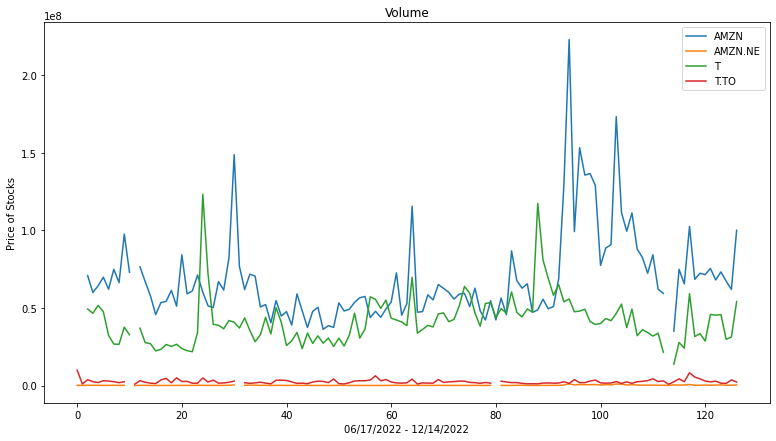

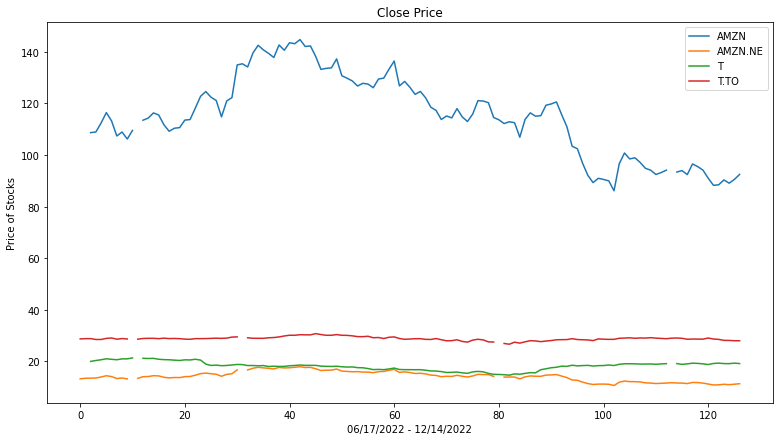

In [26]:
def main() :  
  #get news
  all_news = parse_news(get_all_news_links())

  #store news
  csv_name = download_csv(all_news)

  #search news for stocks
  stock_symbols = get_all_stock_symbols(csv_name)
  all_tickers_found = get_all_tickers(stock_symbols)
  stock_data = get_stock_price_and_volume(all_tickers_found)
  
  #plot graphs of stocks found
  plot_volume(stock_data)
  plot_close(stock_data)

  #recommend users
  recommend(stock_data, stock_symbols)

main()

## Outputs

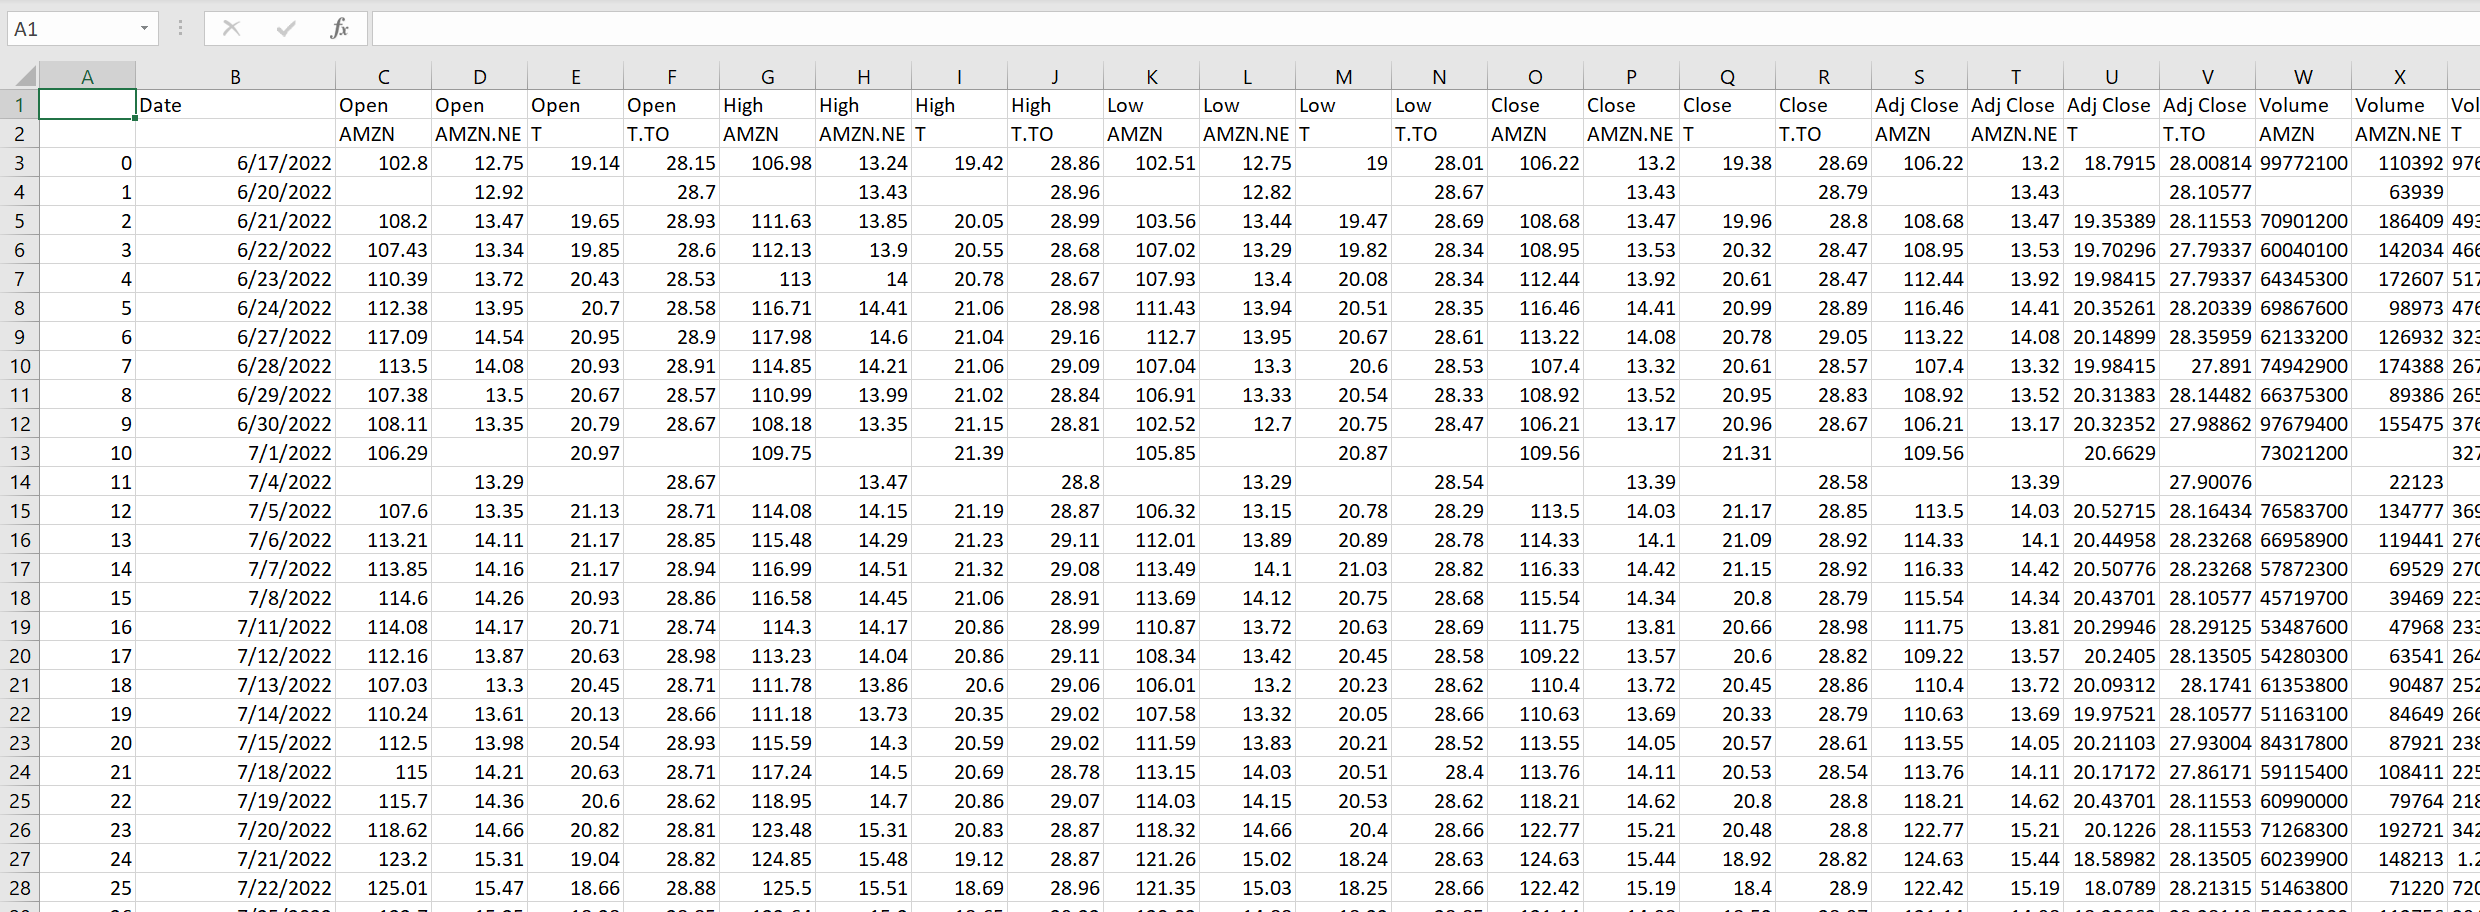

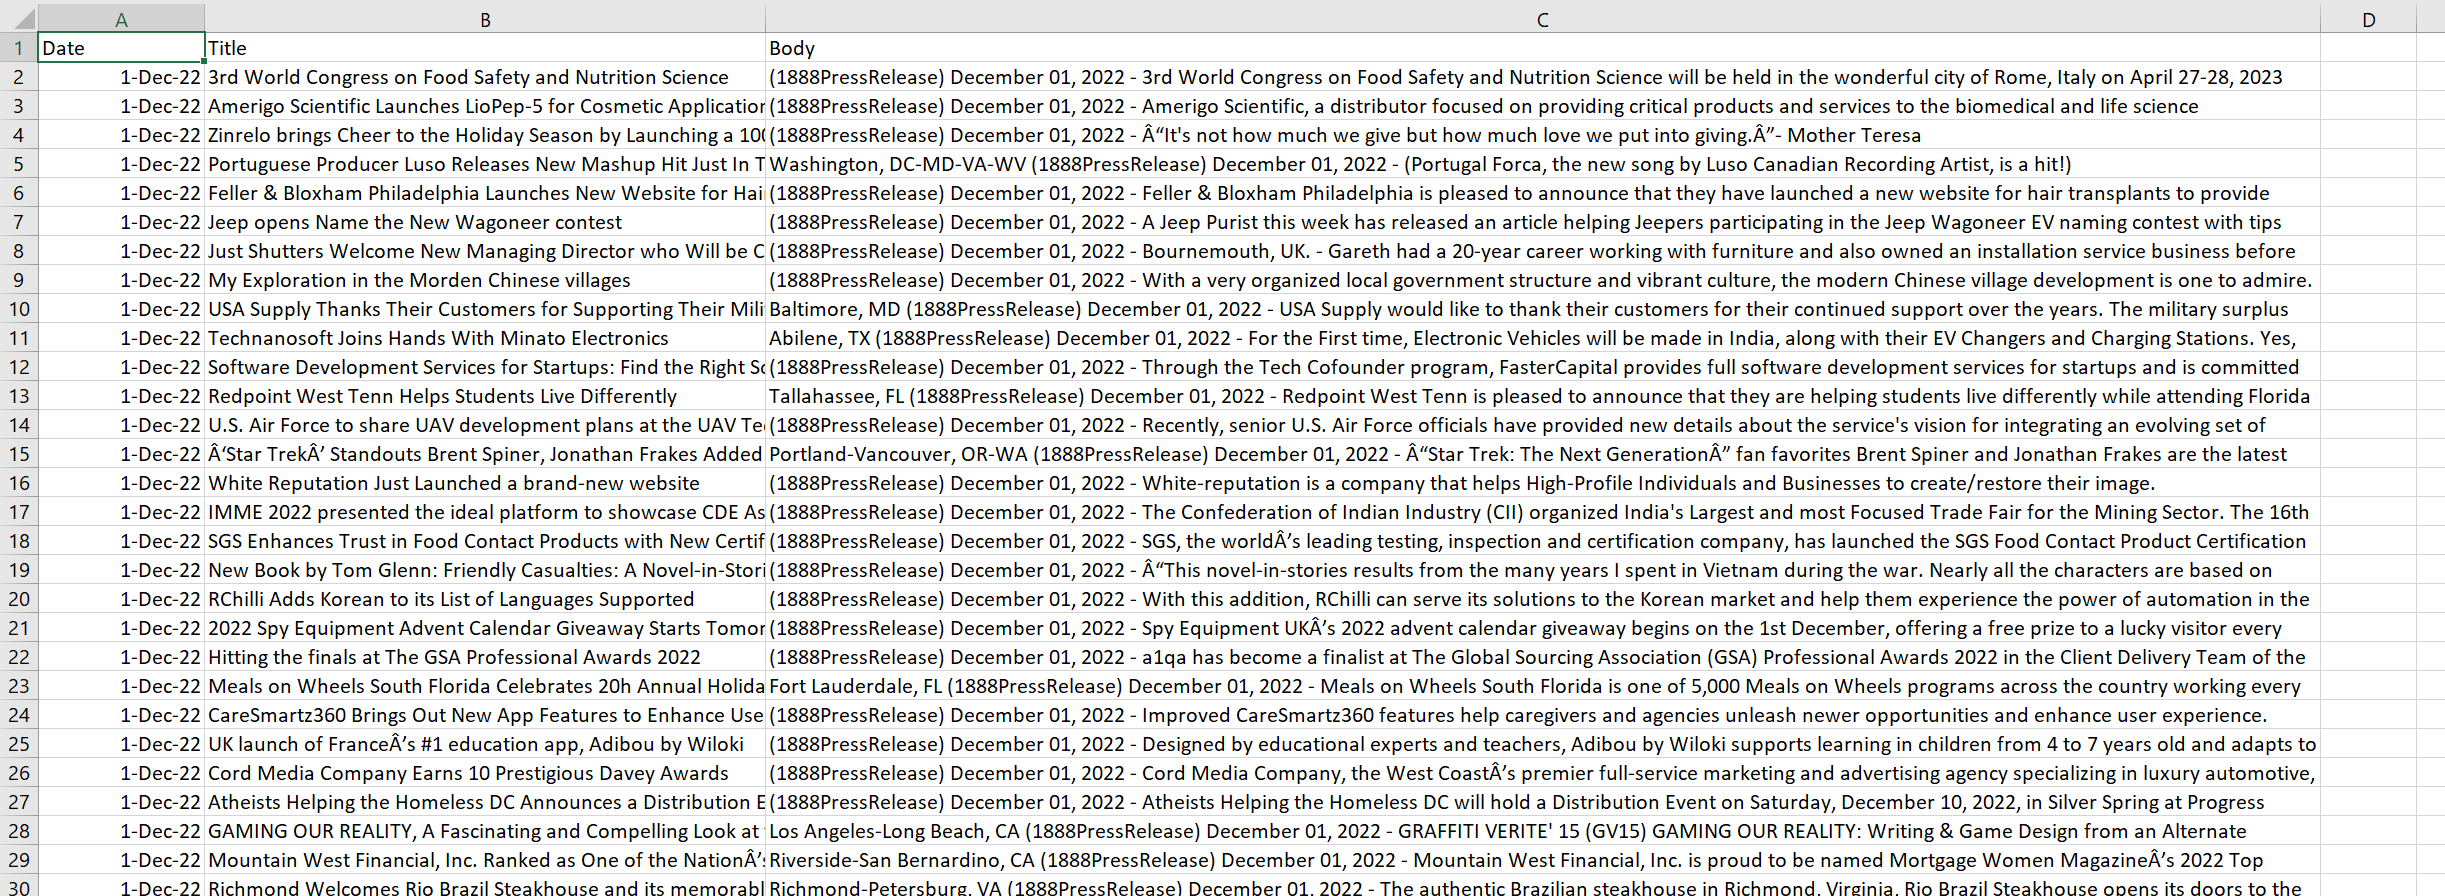

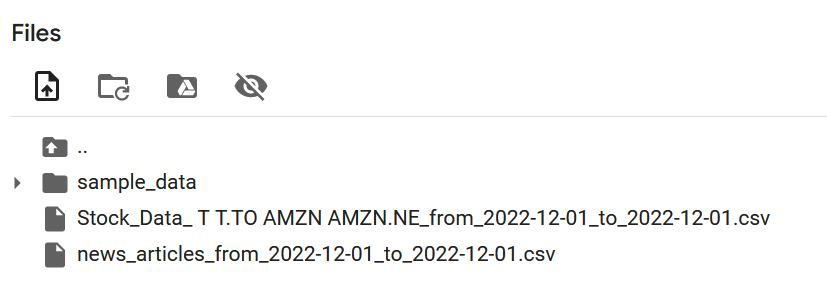

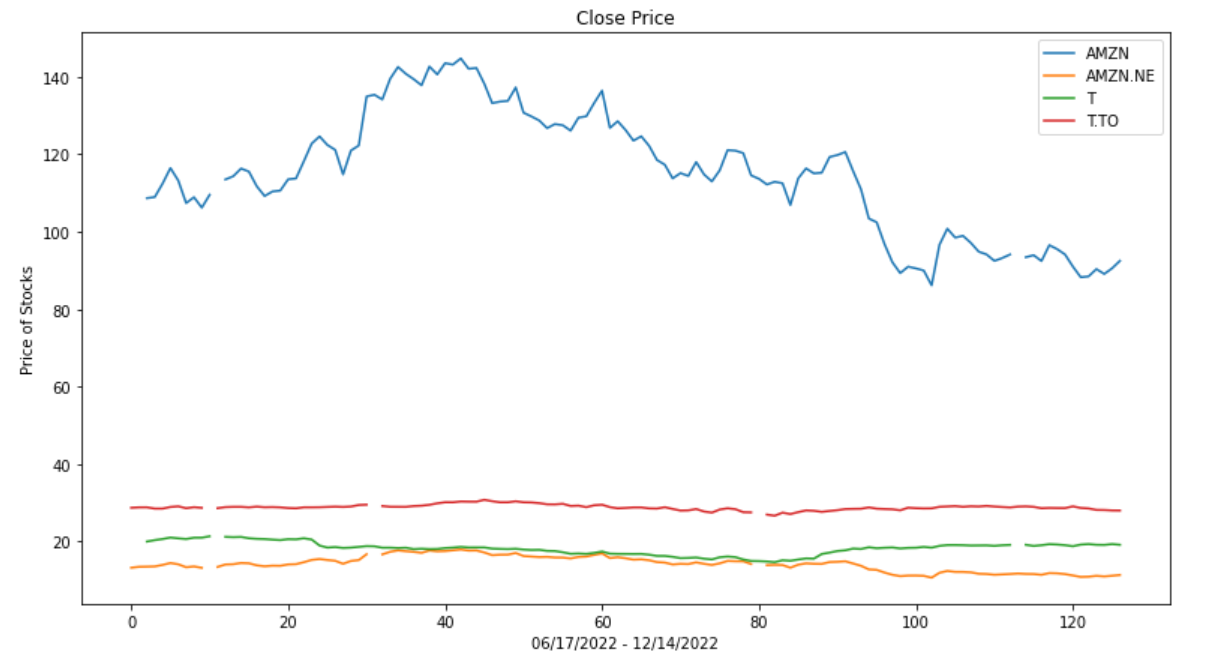

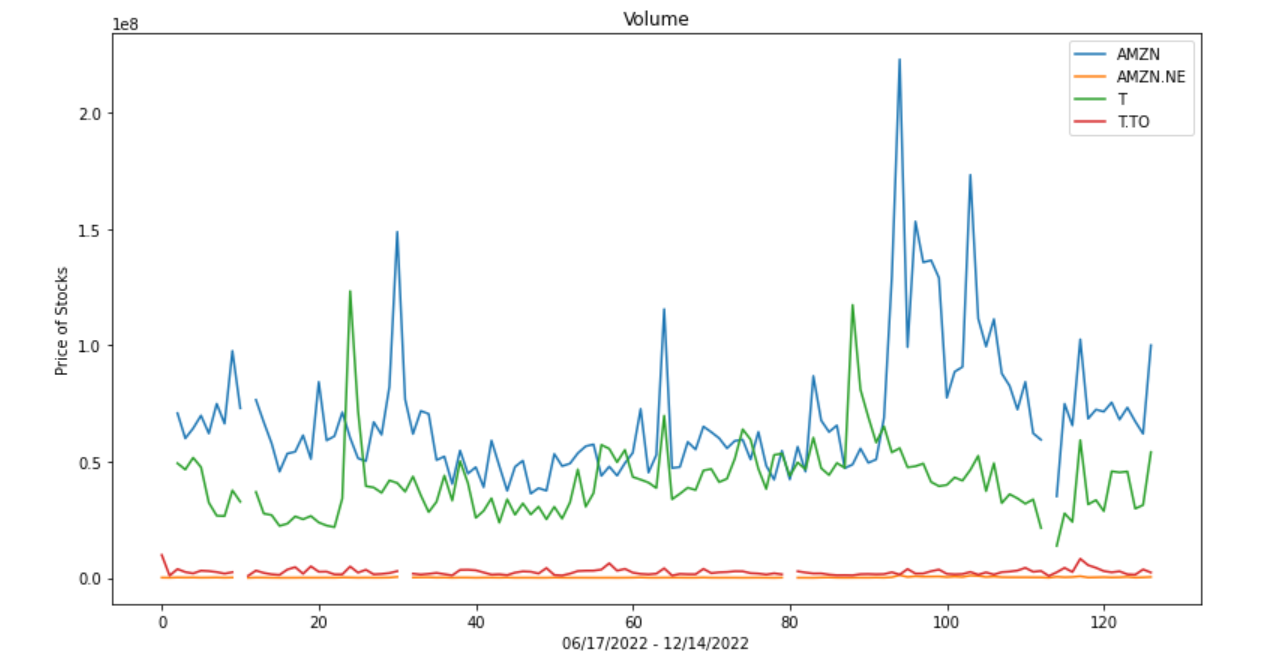

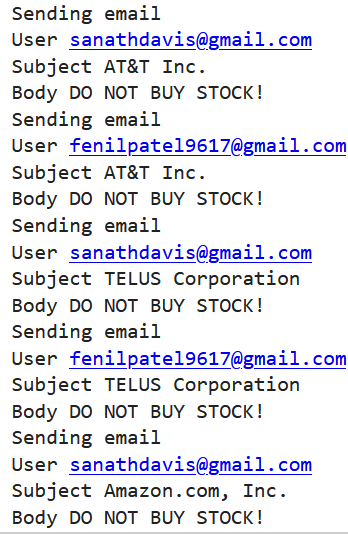

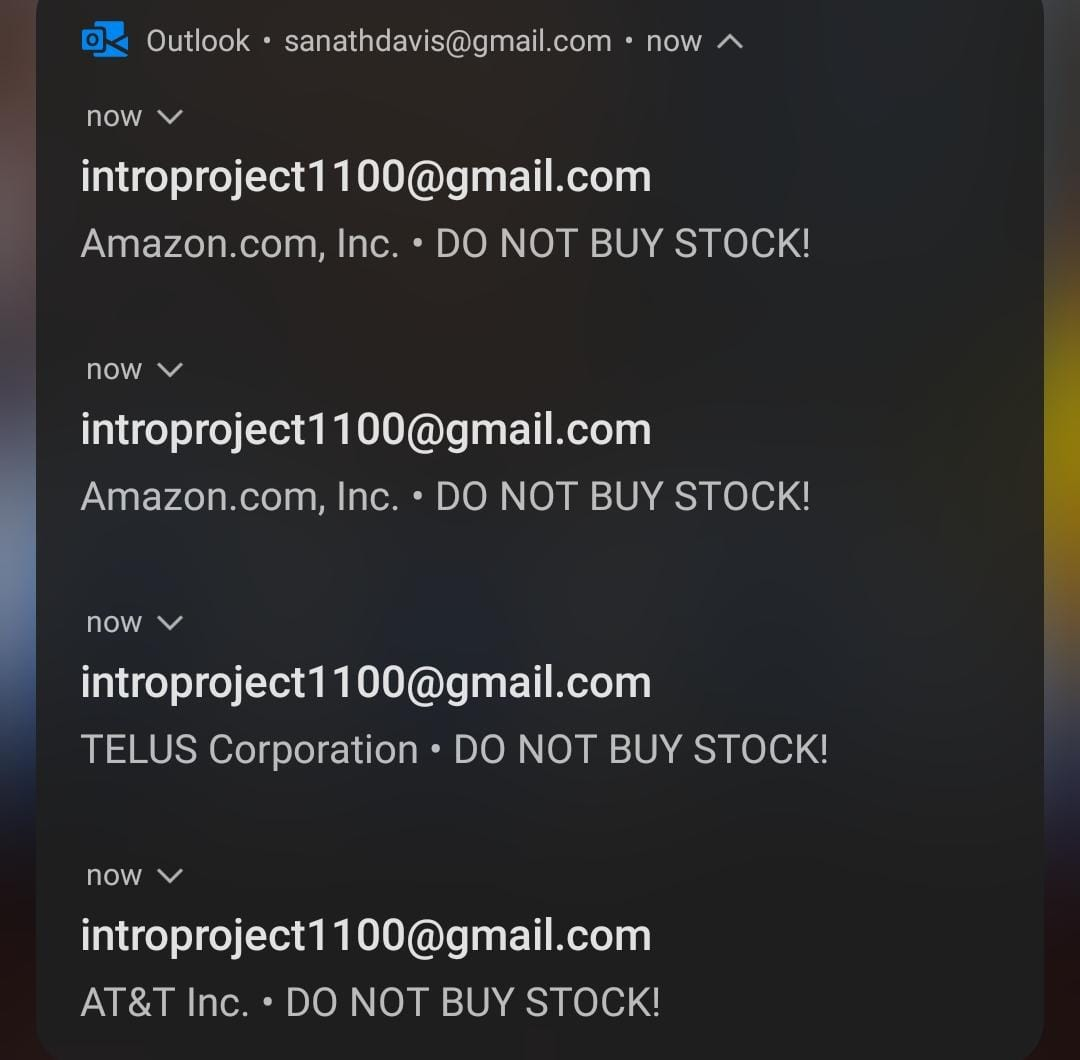
